In [1]:
%config IPCompleter.greedy=True

import pandas
import numpy
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
classes = {
    1: 'normal',
    2: 'hyperthyroidism',
    3: 'hypothyroidism'
}

attributes = [
    'age',
    'sex',
    'on_thyroxine',
    'query_on_thyroxine',
    'on_antithyroid_medication',
    'sick',
    'pregnant',
    'thyroid_surgery',
    'I131_treatment',
    'query_hypothyroid',
    'query_hyperthyroid',
    'lithium',
    'goitre',
    'tumor',
    'hypopituitary',
    'psych',
    'TSH',
    'T3',
    'TT4',
    'T4U',
    'FTI'
]

In [3]:
train_data = []
train_data_labels = []

with open('data/ann-train.data') as data_file:
    train_data = pandas.read_csv(data_file, delimiter=' ', header=None)

train_data = train_data.drop(labels=[22,23], axis='columns')

train_data.columns = attributes + ['class']

train_data_labels = train_data['class']

train_data = train_data.drop('class', axis='columns')

In [4]:
anova_filter = SelectKBest(f_classif, k='all')

anova_filter.fit(train_data, train_data_labels)

attribute_score = [ (name, score) for name, score in zip(train_data.columns, numpy.around(anova_filter.scores_, 2)) ]

attribute_score.sort(key=lambda x: x[1], reverse=True)

print(*('{}: {}'.format(name, score) for name, score in attribute_score), sep='\n')

TSH: 1148.28
FTI: 340.53
TT4: 290.46
T3: 119.54
on_thyroxine: 14.73
query_hypothyroid: 13.97
sex: 4.43
T4U: 2.93
sick: 2.81
psych: 2.64
pregnant: 2.19
thyroid_surgery: 1.6
goitre: 1.36
on_antithyroid_medication: 0.92
query_hyperthyroid: 0.71
query_on_thyroxine: 0.67
age: 0.57
lithium: 0.24
tumor: 0.18
I131_treatment: 0.13
hypopituitary: 0.04


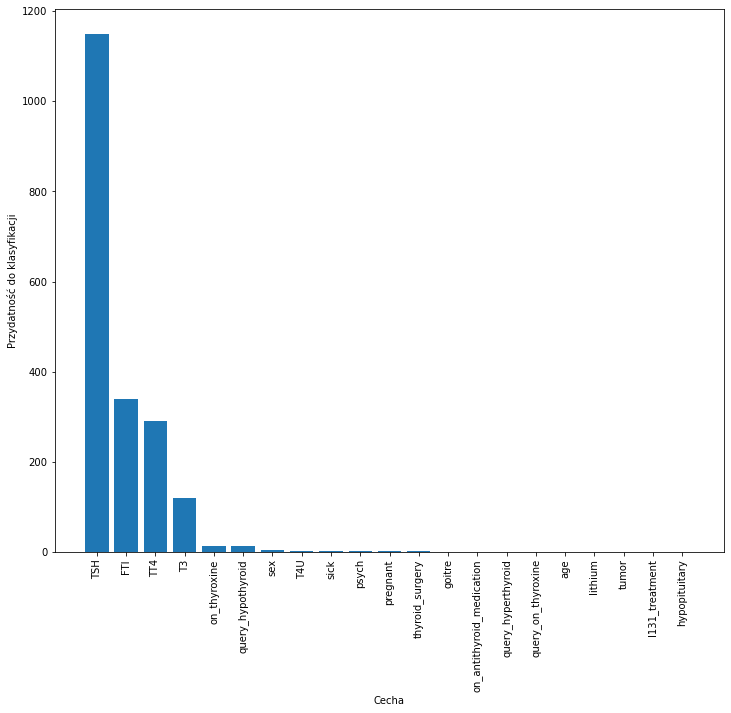

In [16]:
plt.figure(figsize=(12,10))

y_pos = numpy.arange(len(attributes))
plt.bar(y_pos, [ score[1] for score in attribute_score ])
plt.xticks(y_pos, [ score[0] for score in attribute_score ], rotation=90)
plt.xlabel('Cecha')
plt.ylabel('Przydatność do klasyfikacji')
plt.show()

In [6]:
import random
from sklearn import tree
from sklearn import clone
from sklearn.model_selection import cross_val_score

#drzewo decyzyjne cart – 2 różne kryteria podziału oraz 3 wartościmaksymalnej głębokości drzewa.
models = {
    'random3' : tree.DecisionTreeClassifier(max_depth=3, splitter='random'),
    'random6' : tree.DecisionTreeClassifier(max_depth=6, splitter='random'),
    'random12' : tree.DecisionTreeClassifier(max_depth=12, splitter='random'),
    'best3' : tree.DecisionTreeClassifier(max_depth=3, splitter='best'),
    'best6' : tree.DecisionTreeClassifier(max_depth=6, splitter='best'),
    'best12' : tree.DecisionTreeClassifier(max_depth=12, splitter='best'),
}

results = {
    'random3' : [],
    'random6' : [],
    'random12' : [],
    'best3' : [],
    'best6' : [],
    'best12' : [],
}

train_data['class'] = train_data_labels
train_data = train_data.values.tolist()
                                

In [7]:
#dla roznych liczb cech od 1 do 6 cech przeprowadzamy badanie
for iteration in range (0,6):
    feature_count = iteration + 1
    selector = SelectKBest(f_classif, k=feature_count)
    #dla kazdych parametrow drzewa
    for model_name, model_type in models.items():
        test = clone(model_type)
        
        scores = numpy.array([])
        
        #5 razy powtórzona 2-krotna walidacja
        for repetition in range(0,5):
            random.seed(iteration*repetition)
            test.random_state = iteration*repetition
            train_data_shuffled = random.sample(train_data, len(train_data))
            train_data_shuffled = numpy.array(train_data_shuffled)
            train_data_labels = train_data_shuffled[:, train_data_shuffled.shape[1]-1]
            train_data_shuffled = numpy.delete(train_data_shuffled, train_data_shuffled.shape[1]-1, 1)
            
            for fold in range(0,2):
                test_data_begin = fold * int(len(train_data)/2)
                test_data_end = (fold + 1) * int(len(train_data)/2)
                test_data = train_data_shuffled[test_data_begin:test_data_end, :]
                test_data_labels = train_data_labels[test_data_begin:test_data_end]

                if test_data_begin == 0:
                    train_data_new = train_data_shuffled[test_data_end:, :]
                    train_data_new_labels = train_data_labels[test_data_end:]
                else:
                    train_data_new = train_data_shuffled[:test_data_begin, :]
                    train_data_new_labels = train_data_labels[:test_data_begin]

                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore') # to ignore SelectKBest warnings when constant value in column
                    train_data_new = selector.fit_transform(train_data_new, train_data_new_labels)

                test_data = selector.transform(test_data)

                test.fit(train_data_new, train_data_new_labels)

                scores = numpy.append(scores, test.score(test_data, test_data_labels))
                
        
        results[model_name].append((numpy.mean(scores), numpy.std(scores), len(scores)))

In [8]:
#średnie wyniki zaokrąglone do 4 miejsc po przecinku
for model_name in results.keys():
    print(model_name, [round(stat[0],4) for stat in results[model_name]])

random3 [0.9642, 0.9394, 0.9425, 0.9371, 0.9472, 0.9485]
random6 [0.9631, 0.9579, 0.9606, 0.9528, 0.9632, 0.9664]
random12 [0.9616, 0.9672, 0.9686, 0.9647, 0.9747, 0.9804]
best3 [0.9677, 0.9772, 0.9817, 0.9796, 0.9883, 0.9925]
best6 [0.9658, 0.9748, 0.9776, 0.9787, 0.9894, 0.9937]
best12 [0.961, 0.9725, 0.9728, 0.9753, 0.9864, 0.9918]


In [9]:
from scipy import stats

#analiza statystyczna - test parowy t-Studenta

ttest_results = {}

for model_name_1 in results.keys():
    #znalezienie liczby cech, która dała maksymalny średni wynik
    feature_count_1 = numpy.argmax(results[model_name_1], 0)[0]
    #pobranie statystyk dla tej liczby cech
    mean1, std1, nobs1 = results[model_name_1][feature_count_1]
    
    #dla wyników pozostałych klasyfikatorów
    for model_name_2 in results.keys():
        if (model_name_1 != model_name_2):
            feature_count_2 = numpy.argmax(results[model_name_2], 0)[0] #j.w.
            mean2, std2, nobs2 = results[model_name_2][feature_count_2] #j.w.
            
            key = "{}_{}|{}_{}".format(model_name_1, feature_count_1, model_name_2, feature_count_2)
            #test t-studenta dla danych statystyk
            ttest_results[key] = tuple(stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2))

In [10]:
#wyniki testów t-Studenta dla par klasyfikatorów zaokrąglone do 4 miejsc po przecinku
for ttest_key, ttest_result in ttest_results.items():
    print("{}: {:0.4f}, {:0.4f}".format(ttest_key, round(ttest_result[0], 4), round(ttest_result[1], 4)))

random3_0|random6_5: -0.4680, 0.6454
random3_0|random12_5: -7.4803, 0.0000
random3_0|best3_5: -17.3490, 0.0000
random3_0|best6_5: -18.1087, 0.0000
random3_0|best12_5: -16.4845, 0.0000
random6_5|random3_0: 0.4680, 0.6454
random6_5|random12_5: -2.9659, 0.0083
random6_5|best3_5: -5.7995, 0.0000
random6_5|best6_5: -6.0711, 0.0000
random6_5|best12_5: -5.6262, 0.0000
random12_5|random3_0: 7.4803, 0.0000
random12_5|random6_5: 2.9659, 0.0083
random12_5|best3_5: -7.9826, 0.0000
random12_5|best6_5: -8.7948, 0.0000
random12_5|best12_5: -7.3005, 0.0000
best3_5|random3_0: 17.3490, 0.0000
best3_5|random6_5: 5.7995, 0.0000
best3_5|random12_5: 7.9826, 0.0000
best3_5|best6_5: -2.4449, 0.0250
best3_5|best12_5: 1.0936, 0.2885
best6_5|random3_0: 18.1087, 0.0000
best6_5|random6_5: 6.0711, 0.0000
best6_5|random12_5: 8.7948, 0.0000
best6_5|best3_5: 2.4449, 0.0250
best6_5|best12_5: 3.0426, 0.0070
best12_5|random3_0: 16.4845, 0.0000
best12_5|random6_5: 5.6262, 0.0000
best12_5|random12_5: 7.3005, 0.0000
best12_

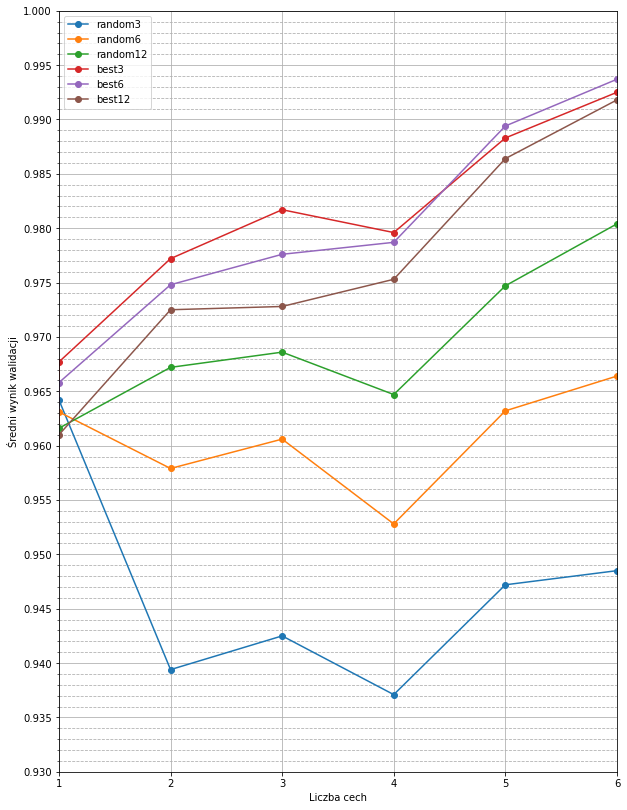

In [11]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(10,14))
plt.grid(True)

plt.xlabel('Liczba cech')
plt.ylabel('Średni wynik walidacji')
plt.axis([1, 6, 0.93, 1])

ax.yaxis.set_major_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.grid(which='minor', linestyle='--')

for model_name in results.keys():
    array_to_draw = [round(stat[0],4) for stat in results[model_name]]
    array_to_draw = [0] + array_to_draw
    plt.plot(array_to_draw, marker='o')

plt.legend(results.keys())

plt.show()